![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

warnings.filterwarnings("ignore")

filename_features = "features.txt"
filename_labels = "activity_labels.txt"

filename_subtrain = "subject_train.txt"
filename_xtrain = "X_train.txt"
filename_ytrain = "y_train.txt"

filename_subtest = "subject_test.txt"
ffilename_xtest = "X_test.txt"
filename_ytest = "y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], squeeze=True, sep="#")
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'], squeeze=True)
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'], squeeze=True)
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [16]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_train_pad.head()

Wall time: 539 ms


,",0,1","0,1,tBodyAcc-mean()-X","1,2,tBodyAcc-mean()-Y","2,3,tBodyAcc-mean()-Z","3,4,tBodyAcc-std()-X","4,5,tBodyAcc-std()-Y","5,6,tBodyAcc-std()-Z","6,7,tBodyAcc-mad()-X","7,8,tBodyAcc-mad()-Y","8,9,tBodyAcc-mad()-Z",...,"551,552,fBodyBodyGyroJerkMag-meanFreq()","552,553,fBodyBodyGyroJerkMag-skewness()","553,554,fBodyBodyGyroJerkMag-kurtosis()","554,555,""angle(tBodyAccMean,gravity)""","555,556,""angle(tBodyAccJerkMean),gravityMean)""","556,557,""angle(tBodyGyroMean,gravityMean)""","557,558,""angle(tBodyGyroJerkMean,gravityMean)""","558,559,""angle(X,gravityMean)""","559,560,""angle(Y,gravityMean)""","560,561,""angle(Z,gravityMean)"""
0,0.200628,-0.063678,-0.419600,-0.868755,-0.939377,-0.737479,-0.859758,-0.938955,-0.766385,-0.855978,...,0.025958,-0.276380,-0.360579,0.062935,-0.778374,-0.026079,-0.687172,0.407918,-0.007567,NaN
1,0.055944,0.031484,-0.253891,-0.875366,-0.923839,-0.849247,-0.868472,-0.921936,-0.848870,-0.871300,...,-0.897296,-0.767938,0.133002,-0.021460,-1.218722,1.484369,-0.694091,0.409089,0.007875,NaN
2,0.073510,-0.043414,-0.076289,-0.868980,-0.907698,-0.893724,-0.863078,-0.898793,-0.896640,-0.863264,...,-0.260860,-0.438286,-0.377815,0.391949,0.151197,1.704085,-0.702191,0.410260,0.026501,NaN
3,0.066691,-0.208407,-0.249695,-0.870566,-0.939959,-0.921743,-0.864445,-0.938060,-0.925216,-0.863264,...,0.591005,0.463123,-0.135016,-0.033635,1.037781,-1.002951,-0.701636,0.414622,0.031712,NaN
4,0.030467,0.027585,-0.109840,-0.875128,-0.934815,-0.921281,-0.867325,-0.931726,-0.927965,-0.870201,...,-0.138505,-0.240296,0.340383,0.268468,1.125841,-1.276196,-0.700104,0.425434,0.045222,NaN


Sem padronização

In [45]:
variavel = ['0,1,tBodyAcc-mean()-X', '1,2,tBodyAcc-mean()-Y', '2,3,tBodyAcc-mean()-Z']

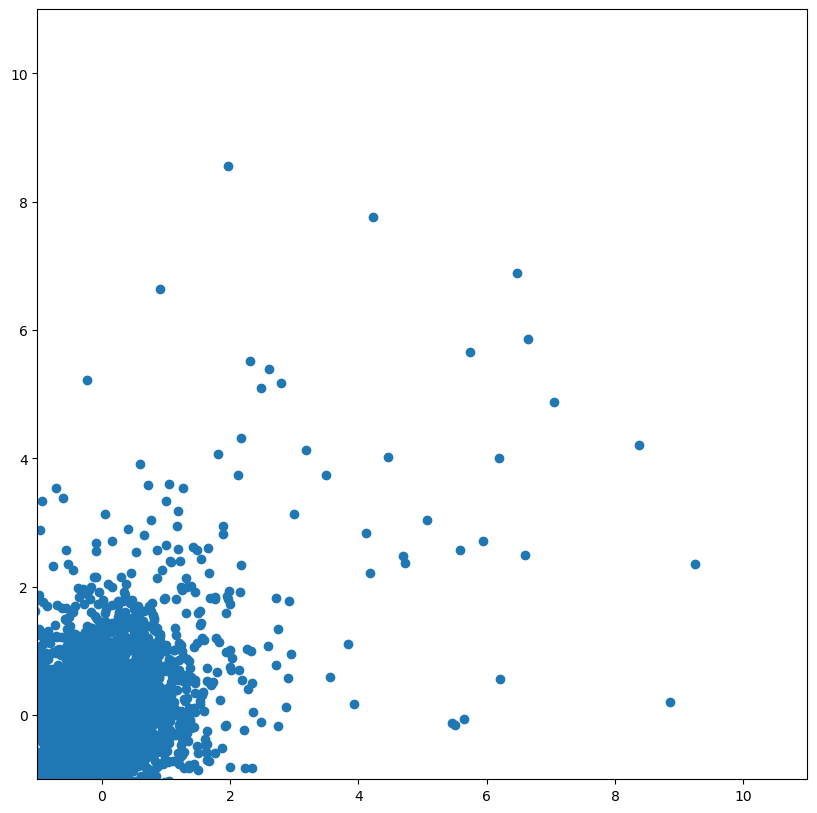

In [46]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)

ax.set_aspect('equal', 'box')
ax.set(xlim=(-1, 11), ylim=(-1, 11));

plt.scatter(x = X_train_pad[variavel[0]], y = X_train_pad[variavel[1]]);

Com padronização

In [47]:
variaveis = ['0,1,tBodyAcc-mean()-X', '1,2,tBodyAcc-mean()-Y', '2,3,tBodyAcc-mean()-Z']

In [48]:
X_train_pad[variaveis].head()

,"0,1,tBodyAcc-mean()-X","1,2,tBodyAcc-mean()-Y","2,3,tBodyAcc-mean()-Z"
0,-0.063678,-0.419600,-0.868755
1,0.031484,-0.253891,-0.875366
2,-0.043414,-0.076289,-0.868980
3,-0.208407,-0.249695,-0.870566
4,0.027585,-0.109840,-0.875128


In [6]:
pca = PCA()

variaveis = ['0,1,tBodyAcc-mean()-X', '1,2,tBodyAcc-mean()-Y', '2,3,tBodyAcc-mean()-Z']
princomp = pca.fit(X_train_pad[variaveis])

componentes = princomp.transform(X_train_pad[variaveis])

principalDF = pd.DataFrame(data = componentes,
                          columns = ['CP1', 'CP2', 'CP3'])

In [9]:
princomp.explained_variance_ / princomp.explained_variance_.sum()

array([0.36107059, 0.33907075, 0.29985866])

In [10]:
X_train_pad[variaveis].cov()

,"0,1,tBodyAcc-mean()-X","1,2,tBodyAcc-mean()-Y","2,3,tBodyAcc-mean()-Z"
"0,1,tBodyAcc-mean()-X",1.000000,-0.078769,-0.045160
"1,2,tBodyAcc-mean()-Y",-0.078769,1.000000,-0.020217
"2,3,tBodyAcc-mean()-Z",-0.045160,-0.020217,1.000000


In [11]:
1.000000 + 1.000000

2.0

In [12]:
1.000000 + -0.020217

0.979783

In [13]:
principalDF.cov()

,CP1,CP2,CP3
CP1,1.083212e+00,1.722046e-16,-8.554351e-17
CP2,1.722046e-16,1.017212e+00,-2.519184e-17
CP3,-8.554351e-17,-2.519184e-17,8.995760e-01


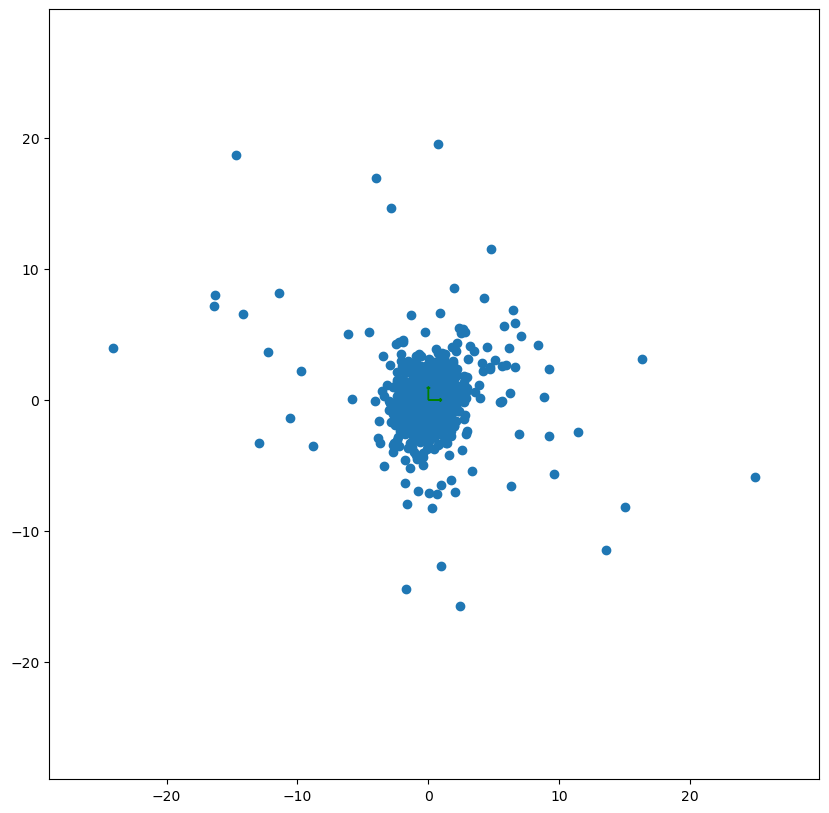

In [27]:
%matplotlib inline
X = X_train_pad[variaveis]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)

x_med = X.iloc[:,0].mean()
y_med = X.iloc[:,1].mean()

ax.scatter(x = X.iloc[:,0], y = X.iloc[:,1])

ampli_x = X.iloc[:,0].max() - X.iloc[:,0].min()
ampli_y = X.iloc[:,0].max() - X.iloc[:,0].min()

xmin = X.iloc[:,0].min() - ampli_x*.1
xmax = X.iloc[:,0].max() + ampli_x*.1
ymin = X.iloc[:,0].min() - ampli_y*.1
ymax = X.iloc[:,0].max() + ampli_y*.1

ax.set_aspect('equal', 'box')
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax));

autovet=princomp.components_

ax.arrow(x_med, y_med, autovet[0,0], autovet[1,0]
        , head_width=0.25
        , head_length=0.1
        , fc='g', ec='g',
        length_includes_head=True)
ax.arrow(x_med, y_med, autovet[0,1], autovet[1,1]
        , head_width=0.25
        , head_length=0.1
        , fc='g', ec='g',
        length_includes_head=True)

<IPython.core.display.Javascript object>


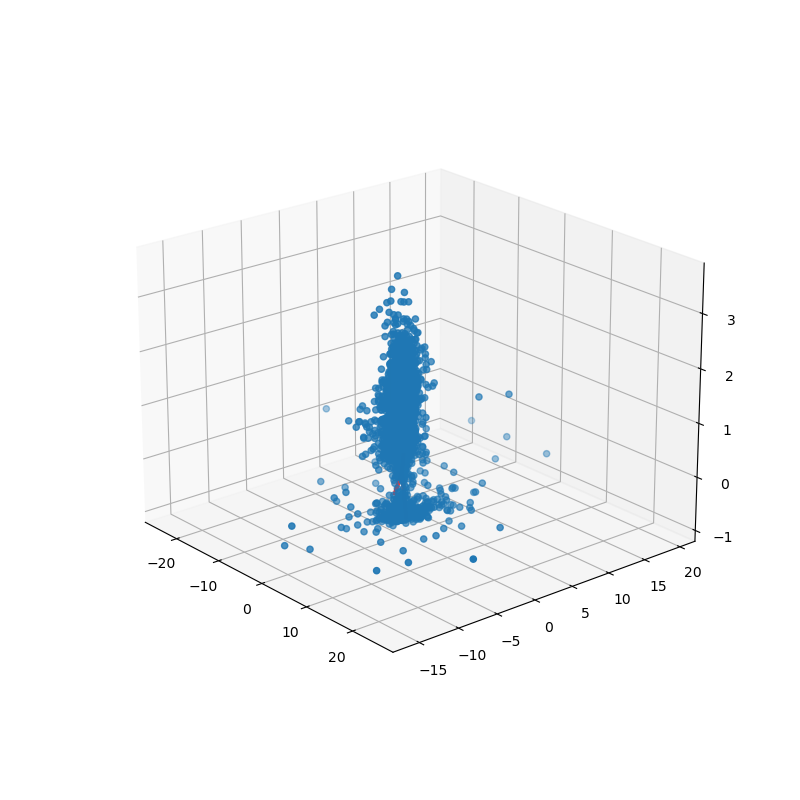

In [28]:
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

variaveis = ['0,1,tBodyAcc-mean()-X', '1,2,tBodyAcc-mean()-Y', '2,3,tBodyAcc-mean()-Z']

pca = PCA()
princomp = pca.fit_transform(X_train_pad[variaveis])
autovet = pca.components_
autoval = pca.explained_variance_

ax.scatter( X_train_pad[variaveis[0]], X_train_pad[variaveis[1]], X_train_pad[variaveis[2]] )


for i, v in enumerate(autovet):
    ax.plot([X_train_pad[variaveis[0]].mean(), X_train_pad[variaveis[0]].mean()+v[0]*autoval[i]**.5], 
            [ X_train_pad[variaveis[1]].mean(), X_train_pad[variaveis[1]].mean()+v[1]*autoval[i]**.5], 
            [X_train_pad[variaveis[2]].mean(), X_train_pad[variaveis[2]].mean()+v[2]*autoval[i]**.5], 
            color='red', 
            alpha=0.8, 
            lw=3)

In [14]:
pca = PCA()

n_componentes = principalDF.shape[1]

princomp = pca.fit(principalDF)

componentes = princomp.transform(principalDF)
nomes_pca = ['CP'+str(x+1) for x in list(range(n_componentes))]

principalDF = pd.DataFrame(data = componentes
                          ,columns = nomes_pca)

In [15]:
principalDF.head()

,CP1,CP2,CP3
0,-0.431391,0.551367,0.666896
1,-0.397575,0.647107,0.504880
2,-0.228354,0.716677,0.443913
3,-0.217853,0.616036,0.660838
4,-0.303208,0.714688,0.419477


## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [62]:
X = X_train_pad[variaveis]
y = X_train_pad[variavel]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [66]:
%%time
tree = DecisionTreeClassifier(min_samples_leaf=10, ccp_alpha=0.001)

Wall time: 0 ns
